In [1]:
import pathlib
import tensorflow as tf
from tensorflow.keras import utils, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Add, BatchNormalization, Activation

from keras.models import Model
from tensorflow.keras.applications import resnet

from keras.initializers import glorot_uniform

2023-04-24 20:45:12.541079: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-24 20:45:34.534529: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 20:46:03.131379: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Loading

In [2]:
dataset = utils.image_dataset_from_directory(
    './figs',
    labels="inferred",
    label_mode="int",
    class_names=['class0', 'class1', 'class2', 'class3'],
    color_mode="rgb",
    batch_size=64,
    image_size=(258, 347),
    shuffle=True,
    seed=109,
    validation_split=0.2,
    subset='both',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)
trainset, valset = dataset

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Using 1600 files for validation.


2023-04-24 20:46:49.862178: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-24 20:46:56.231384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-24 20:46:56.231688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Configure the Dataset for Performance

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

trainset = trainset.cache().prefetch(buffer_size=AUTOTUNE)
valset = valset.cache().prefetch(buffer_size=AUTOTUNE)

##normalize the images
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train = trainset.map(lambda x, y: (normalization_layer(x), y))
normalized_val = valset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


2023-04-24 20:48:05.299594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6400]
	 [[{{node Placeholder/_0}}]]
2023-04-24 20:48:05.300128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6400]
	 [[{{node Placeholder/_0}}]]
2023-04-24 20:48:07.931712: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pip

0.15294118 1.0


## Build the ResNet18 model

In [4]:
img_rows, img_cols =258, 347
input_shape = (img_rows, img_cols, 3)

input1 = Input(shape=input_shape)

# Resuidal block BN -> relu -> conv -> bn -> relu -> conv
def res_block(x, filters):
    bn1 = BatchNormalization()(x)
    act1 = Activation('relu')(bn1)
    conv1 = Conv2D(filters=filters, kernel_size=(3, 3), data_format='channels_first', strides=(2, 2), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(act1)
    print('conv1.shape', conv1.shape)
    bn2 = BatchNormalization()(conv1)
    act2 = Activation('relu')(bn2)
    conv2 = Conv2D(filters=filters, kernel_size=(3, 3), data_format='channels_first', strides=(1, 1), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(act2)
    print('conv2.shape', conv2.shape)
    residual = Conv2D(1, (1, 1), strides=(1, 1), data_format='channels_first')(conv2)
    
    
    x = Conv2D(filters=filters, kernel_size=(3, 3), data_format='channels_first', strides=(2, 2), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(x)
    print('x.shape', x.shape)
    out = Add()([x, residual])
    
    return out

# Combining resuidal blocks into a network
res1 = res_block(input1, 64)
print('---------block 1 end-----------')
res2 = res_block(res1, 128)
print('---------block 2 end-----------')
res3 = res_block(res2, 256)
print('---------block 3 end-----------')
res4 = res_block(res3, 512)
print('---------block 4 end-----------')

# Classifier block
act1 = Activation('relu')(res4)
flatten1 = Flatten()(act1)
dense1 = Dense(512)(flatten1)
act2 = Activation('relu')(dense1)
dense2 = Dense(4)(act2)
output1 = Activation('softmax')(dense2)

resnet18 = Model(inputs=input1, outputs=output1)

conv1.shape (None, 64, 174, 2)
conv2.shape (None, 64, 174, 2)
x.shape (None, 64, 174, 2)
---------block 1 end-----------
conv1.shape (None, 128, 87, 1)
conv2.shape (None, 128, 87, 1)
x.shape (None, 128, 87, 1)
---------block 2 end-----------
conv1.shape (None, 256, 44, 1)
conv2.shape (None, 256, 44, 1)
x.shape (None, 256, 44, 1)
---------block 3 end-----------
conv1.shape (None, 512, 22, 1)
conv2.shape (None, 512, 22, 1)
x.shape (None, 512, 22, 1)
---------block 4 end-----------


In [5]:
resnet18.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 258, 347, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 258, 347, 3)  12         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 258, 347, 3)  0           ['batch_normalization[0][0]']    
                                                                                              

 conv2d_15 (Conv2D)             (None, 512, 22, 1)   1180160     ['add_2[0][0]']                  
                                                                                                  
 conv2d_14 (Conv2D)             (None, 1, 22, 1)     513         ['conv2d_13[0][0]']              
                                                                                                  
 add_3 (Add)                    (None, 512, 22, 1)   0           ['conv2d_15[0][0]',              
                                                                  'conv2d_14[0][0]']              
                                                                                                  
 activation_8 (Activation)      (None, 512, 22, 1)   0           ['add_3[0][0]']                  
                                                                                                  
 flatten (Flatten)              (None, 11264)        0           ['activation_8[0][0]']           
          

In [6]:
# Compiling the model
resnet18.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [56]:
#define early stopping
es = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=0)
##define automatic saving 
save = ModelCheckpoint(
    "./models/resnet18",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
)

In [57]:
##fit 
%time
resnet18.fit(
  normalized_train,
  validation_data=normalized_val,
    epochs=30, callbacks=[es, save]  
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 1.1994 - accuracy: 0.4614
Epoch 1: val_accuracy improved from -inf to 0.34938, saving model to ./models/resnet18


INFO:tensorflow:Assets written to: ./models/resnet18/assets


INFO:tensorflow:Assets written to: ./models/resnet18/assets


100/100 [==============================] - 22s 150ms/step - loss: 1.1994 - accuracy: 0.4614 - val_loss: 1.2937 - val_accuracy: 0.3494
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.5853 - accuracy: 0.7678
Epoch 2: val_accuracy improved from 0.34938 to 0.47375, saving model to ./models/resnet18


INFO:tensorflow:Assets written to: ./models/resnet18/assets


INFO:tensorflow:Assets written to: ./models/resnet18/assets


100/100 [==============================] - 15s 146ms/step - loss: 0.5853 - accuracy: 0.7678 - val_loss: 3.2549 - val_accuracy: 0.4737
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.3303 - accuracy: 0.8775
Epoch 3: val_accuracy improved from 0.47375 to 0.67437, saving model to ./models/resnet18


INFO:tensorflow:Assets written to: ./models/resnet18/assets


INFO:tensorflow:Assets written to: ./models/resnet18/assets


100/100 [==============================] - 15s 147ms/step - loss: 0.3303 - accuracy: 0.8775 - val_loss: 1.2687 - val_accuracy: 0.6744
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 0.2400 - accuracy: 0.9119
Epoch 4: val_accuracy improved from 0.67437 to 0.89062, saving model to ./models/resnet18


INFO:tensorflow:Assets written to: ./models/resnet18/assets


INFO:tensorflow:Assets written to: ./models/resnet18/assets


100/100 [==============================] - 14s 141ms/step - loss: 0.2400 - accuracy: 0.9119 - val_loss: 0.4585 - val_accuracy: 0.8906
Epoch 5/30
100/100 [==============================] - ETA: 0s - loss: 0.1917 - accuracy: 0.9305
Epoch 5: val_accuracy improved from 0.89062 to 0.92937, saving model to ./models/resnet18


INFO:tensorflow:Assets written to: ./models/resnet18/assets


INFO:tensorflow:Assets written to: ./models/resnet18/assets


100/100 [==============================] - 15s 145ms/step - loss: 0.1917 - accuracy: 0.9305 - val_loss: 0.2349 - val_accuracy: 0.9294
Epoch 6/30
100/100 [==============================] - ETA: 0s - loss: 0.1809 - accuracy: 0.9353
Epoch 6: val_accuracy improved from 0.92937 to 0.93313, saving model to ./models/resnet18


INFO:tensorflow:Assets written to: ./models/resnet18/assets


INFO:tensorflow:Assets written to: ./models/resnet18/assets


100/100 [==============================] - 15s 147ms/step - loss: 0.1809 - accuracy: 0.9353 - val_loss: 0.2435 - val_accuracy: 0.9331
Epoch 7/30
100/100 [==============================] - ETA: 0s - loss: 0.1839 - accuracy: 0.9320
Epoch 7: val_accuracy did not improve from 0.93313
100/100 [==============================] - 9s 93ms/step - loss: 0.1839 - accuracy: 0.9320 - val_loss: 0.2854 - val_accuracy: 0.9300
Epoch 8/30
100/100 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9458
Epoch 8: val_accuracy improved from 0.93313 to 0.94937, saving model to ./models/resnet18


INFO:tensorflow:Assets written to: ./models/resnet18/assets


INFO:tensorflow:Assets written to: ./models/resnet18/assets


100/100 [==============================] - 15s 146ms/step - loss: 0.1483 - accuracy: 0.9458 - val_loss: 0.2105 - val_accuracy: 0.9494
Epoch 9/30
100/100 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.9503
Epoch 9: val_accuracy improved from 0.94937 to 0.95500, saving model to ./models/resnet18


INFO:tensorflow:Assets written to: ./models/resnet18/assets


INFO:tensorflow:Assets written to: ./models/resnet18/assets


100/100 [==============================] - 14s 141ms/step - loss: 0.1407 - accuracy: 0.9503 - val_loss: 0.1789 - val_accuracy: 0.9550
Epoch 10/30
100/100 [==============================] - ETA: 0s - loss: 0.1027 - accuracy: 0.9623
Epoch 10: val_accuracy did not improve from 0.95500
100/100 [==============================] - 9s 93ms/step - loss: 0.1027 - accuracy: 0.9623 - val_loss: 0.1880 - val_accuracy: 0.9519
Epoch 11/30
100/100 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9712
Epoch 11: val_accuracy improved from 0.95500 to 0.95625, saving model to ./models/resnet18


INFO:tensorflow:Assets written to: ./models/resnet18/assets


INFO:tensorflow:Assets written to: ./models/resnet18/assets


100/100 [==============================] - 15s 147ms/step - loss: 0.0763 - accuracy: 0.9712 - val_loss: 0.1731 - val_accuracy: 0.9563
Epoch 12/30
100/100 [==============================] - ETA: 0s - loss: 0.1467 - accuracy: 0.9481
Epoch 12: val_accuracy did not improve from 0.95625
100/100 [==============================] - 9s 93ms/step - loss: 0.1467 - accuracy: 0.9481 - val_loss: 0.4937 - val_accuracy: 0.8106
Epoch 13/30
100/100 [==============================] - ETA: 0s - loss: 0.1251 - accuracy: 0.9530
Epoch 13: val_accuracy did not improve from 0.95625
100/100 [==============================] - 9s 94ms/step - loss: 0.1251 - accuracy: 0.9530 - val_loss: 0.2056 - val_accuracy: 0.9413
Epoch 14/30
100/100 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9755
Epoch 14: val_accuracy did not improve from 0.95625
100/100 [==============================] - 9s 94ms/step - loss: 0.0687 - accuracy: 0.9755 - val_loss: 0.4616 - val_accuracy: 0.9175
Epoch 15/30
100/100 [==

INFO:tensorflow:Assets written to: ./models/resnet18/assets


INFO:tensorflow:Assets written to: ./models/resnet18/assets


100/100 [==============================] - 15s 148ms/step - loss: 0.0344 - accuracy: 0.9877 - val_loss: 0.2153 - val_accuracy: 0.9575
Epoch 21/30
100/100 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9895
Epoch 21: val_accuracy did not improve from 0.95750
100/100 [==============================] - 10s 95ms/step - loss: 0.0328 - accuracy: 0.9895 - val_loss: 0.2520 - val_accuracy: 0.9162
Epoch 22/30
100/100 [==============================] - ETA: 0s - loss: 0.0570 - accuracy: 0.9830
Epoch 22: val_accuracy did not improve from 0.95750
100/100 [==============================] - 9s 94ms/step - loss: 0.0570 - accuracy: 0.9830 - val_loss: 0.1686 - val_accuracy: 0.9538
Epoch 23/30
100/100 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9831
Epoch 23: val_accuracy improved from 0.95750 to 0.96750, saving model to ./models/resnet18


INFO:tensorflow:Assets written to: ./models/resnet18/assets


INFO:tensorflow:Assets written to: ./models/resnet18/assets


100/100 [==============================] - 15s 148ms/step - loss: 0.0544 - accuracy: 0.9831 - val_loss: 0.1533 - val_accuracy: 0.9675
Epoch 24/30
100/100 [==============================] - ETA: 0s - loss: 0.0606 - accuracy: 0.9767
Epoch 24: val_accuracy did not improve from 0.96750
100/100 [==============================] - 10s 95ms/step - loss: 0.0606 - accuracy: 0.9767 - val_loss: 0.1640 - val_accuracy: 0.9600
Epoch 25/30
100/100 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9873
Epoch 25: val_accuracy did not improve from 0.96750
100/100 [==============================] - 10s 95ms/step - loss: 0.0399 - accuracy: 0.9873 - val_loss: 0.2252 - val_accuracy: 0.9588
Epoch 26/30
100/100 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 0.9847
Epoch 26: val_accuracy did not improve from 0.96750
100/100 [==============================] - 10s 95ms/step - loss: 0.0416 - accuracy: 0.9847 - val_loss: 0.1788 - val_accuracy: 0.9569
Epoch 27/30
100/100 

0.9674999713897705


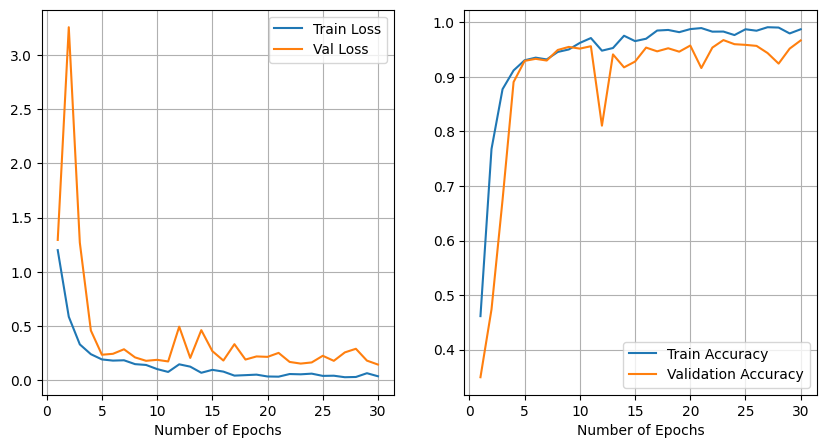

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(1, len(resnet18.history.history['loss'])+1), resnet18.history.history['loss'], 
           label='Train Loss');
ax[0].plot(range(1, len(resnet18.history.history['val_loss'])+1), 
         resnet18.history.history['val_loss'], label='Val Loss');
ax[0].grid();
ax[0].legend();
ax[0].set_xlabel("Number of Epochs");
ax[1].plot(range(1, len(resnet18.history.history['accuracy'])+1),resnet18.history.history['accuracy'],
          label = 'Train Accuracy')
ax[1].plot(range(1, len(resnet18.history.history['val_accuracy'])+1), resnet18.history.history['val_accuracy'], 
          label = 'Validation Accuracy')
ax[1].grid();
ax[1].legend();
ax[1].set_xlabel("Number of Epochs");
print(max(resnet18.history.history['val_accuracy']))

In [7]:
##reload the model
resnet18 = tf.keras.models.load_model("./models/resnet18")

In [8]:
resnet18.evaluate(normalized_val)

2023-04-24 20:49:56.483427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]
2023-04-24 20:49:56.483766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]
2023-04-24 20:51:05.378319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-24 20:52:00.810797: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


25/25 [==============================] - 132s 104ms/step - loss: 0.1533 - accuracy: 0.9675


[0.15334583818912506, 0.9674999713897705]

## Now Test on the Test Image

In [46]:
##load the test image
testset1 = utils.image_dataset_from_directory(
    './test/class1',
    labels=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(258, 347),
    shuffle=False,
    seed=109,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

testset2 = utils.image_dataset_from_directory(
    './test/class2',
    labels=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(258, 347),
    shuffle=False,
    seed=109,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

testset3 = utils.image_dataset_from_directory(
    './test/class3',
    labels=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(258, 347),
    shuffle=False,
    seed=109,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

##normalize the testset
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_testset1 = testset1.map(lambda x: normalization_layer(x))
normalized_testset2 = testset2.map(lambda x: normalization_layer(x))
normalized_testset3 = testset3.map(lambda x: normalization_layer(x))

Found 1800 files belonging to 1 classes.
Found 1414 files belonging to 1 classes.
Found 1800 files belonging to 1 classes.


In [47]:
##predict
prediction1 = np.array([x.argmax() for x in resnet18.predict(normalized_testset1)])
prediction2 = np.array([x.argmax() for x in resnet18.predict(normalized_testset2)]) 
prediction3 = np.array([x.argmax() for x in resnet18.predict(normalized_testset3)])

29/29 [==============================] - 3s 89ms/step


In [48]:
##class1
print(np.unique(prediction1))
print("Number of prediction 0: {}".format((prediction1==0).sum()))
print("Number of prediction 1: {}".format((prediction1==1).sum()))
print("Number of prediction 2: {}".format((prediction1==2).sum()))
print("Number of prediction 3: {}".format((prediction1==3).sum()))

[0 1 2 3]
Number of prediction 0: 1764
Number of prediction 1: 15
Number of prediction 2: 16
Number of prediction 3: 5


In [49]:
#class2
print(np.unique(prediction2))
print("Number of prediction 0: {}".format((prediction2==0).sum()))
print("Number of prediction 1: {}".format((prediction2==1).sum()))
print("Number of prediction 2: {}".format((prediction2==2).sum()))
print("Number of prediction 3: {}".format((prediction2==3).sum()))

[0 2 3]
Number of prediction 0: 1383
Number of prediction 1: 0
Number of prediction 2: 8
Number of prediction 3: 23


In [50]:
#class3
print(np.unique(prediction3))
print("Number of prediction 0: {}".format((prediction3==0).sum()))
print("Number of prediction 1: {}".format((prediction3==1).sum()))
print("Number of prediction 2: {}".format((prediction3==2).sum()))
print("Number of prediction 3: {}".format((prediction3==3).sum()))

[0 2 3]
Number of prediction 0: 1758
Number of prediction 1: 0
Number of prediction 2: 4
Number of prediction 3: 38


### Examine how the model sees the image by saliency maps

In [51]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore

def get_img(batch, index, img_set):
    i = index // batch; j = index % batch
    batch_ = list(iter(img_set.skip(index).take(1)))[0]
    img = batch_[0][j]
    label = batch_[1][j]
    return img, int(label)

##our model returns probability, so need to transform back to logit
def model_modifier(model):
    model.layers[-1].activation=tf.keras.activations.linear

def generate_saliency_map(model, modifier, img, class_index, smooth=0):
    saliency = Saliency(model, model_modifier=modifier, clone=True)
    score = CategoricalScore([class_index])
    saliency_map = saliency(score, img, smooth)
    return saliency_map

def generate_gradcam(model, modifier, img, class_idx):
    gradcam = Gradcam(model, model_modifier=modifier, clone=True)
    score = CategoricalScore([class_idx])
    results = gradcam(score, img)
    return results

##this function plot the saliency maps when the prediction is correct
def plot_saliency_correct(model, modifier, img, class_idx):
    sg_saliency = generate_saliency_map(model, modifier, img, class_idx, smooth=1)[0]
    gc_saliency = generate_gradcam(model, modifier, img, class_idx)[0]
    fig, ax = plt.subplots(1, 2, figsize=(8, 4));
    ax[0].imshow(sg_saliency, cmap='gist_heat', alpha=1);
    ax[0].imshow(img, alpha=0.3);
    ax[0].axis('off');
    ax[0].set_title("Smooth-Grad Saliency Map of class {}".format(class_idx));
    ax[1].imshow(gc_saliency, cmap='gist_heat', alpha=1);
    ax[1].imshow(img, alpha=0.3);
    ax[1].axis('off');
    ax[1].set_title("GradCam Saliency Map of class {}".format(class_idx));
    
##this function plot the saliency maps when the prediction is incorrect
def plot_saliency_wrong(model, modifier, img, real_class, pred_class):
    sg_saliency_real = generate_saliency_map(model, modifier, img, real_class, smooth=1)[0]
    gc_saliency_real = generate_gradcam(model, modifier, img, real_class)[0]
    sg_saliency_pred = generate_saliency_map(model, modifier, img, pred_class, smooth=1)[0]
    gc_saliency_pred = generate_gradcam(model, modifier, img, pred_class)[0]
    fig, ax = plt.subplots(2, 2, figsize=(8, 8));
    ax[0][0].imshow(sg_saliency_real, cmap='gist_heat', alpha=1);
    ax[0][0].imshow(img, alpha=0.2);
    ax[0][0].axis('off');
    ax[0][0].set_title("Smooth-Grad Saliency Map of class {}".format(real_class));
    ax[0][1].imshow(gc_saliency_real, cmap='gist_heat', alpha=1);
    ax[0][1].imshow(img, alpha=0.2);
    ax[0][1].axis('off');
    ax[0][1].set_title("GradCam Saliency Map of class {}".format(real_class));
    ax[1][0].imshow(sg_saliency_pred, cmap='gist_heat', alpha=1);
    ax[1][0].imshow(img, alpha=0.2);
    ax[1][0].axis('off');
    ax[1][0].set_title("Smooth-Grad Saliency Map of class {}".format(pred_class));
    ax[1][1].imshow(gc_saliency_pred, cmap='gist_heat', alpha=1);
    ax[1][1].imshow(img, alpha=0.2);
    ax[1][1].axis('off');
    ax[1][1].set_title("GradCam Saliency Map of class {}".format(pred_class));

### Examine How the Model sees the images in the train and validation Images first

In [72]:
one_batch_val = list(iter(normalized_val.skip(0).take(1)))
index0 = np.where(one_batch_val[0][1].numpy()==0)[0]
index1 = np.where(one_batch_val[0][1].numpy()==1)[0]
index2 = np.where(one_batch_val[0][1].numpy()==2)[0]
index3 = np.where(one_batch_val[0][1].numpy()==3)[0]

2023-04-04 02:45:57.196826: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [79]:
val_img0 = one_batch_val[0][0][index0[0]]
val_img1 = one_batch_val[0][0][index1[0]]
val_img2 = one_batch_val[0][0][index2[0]]
val_img3 = one_batch_val[0][0][index3[0]]
single_pred0 = resnet18.predict(np.expand_dims(val_img0, axis=0)).argmax()
single_pred1 = resnet18.predict(np.expand_dims(val_img1, axis=0)).argmax()
single_pred2 = resnet18.predict(np.expand_dims(val_img2, axis=0)).argmax()
single_pred3 = resnet18.predict(np.expand_dims(val_img3, axis=0)).argmax()

1/1 [==============================] - 0s 21ms/step


Model corrected predicted 0


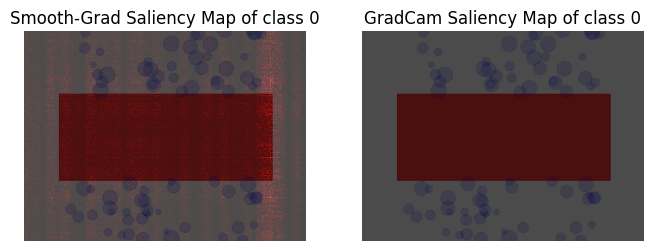

In [81]:
if single_pred0 == 0:
    print("Model correctly predicted 0")
    plot_saliency_correct(resnet18, model_modifier, val_img0, 0)
else:
    print("Model misclassified as: {}, but shoud be 0".format(single_pred0))
    plot_saliency_wrong(resnet18, model_modifier, val_img0, 0, single_pred0)

Model corrected predicted 1


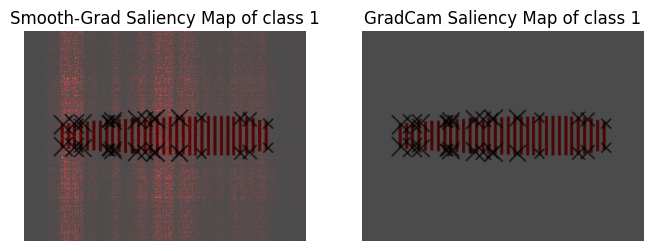

In [82]:
if single_pred1 == 1:
    print("Model correctly predicted 1")
    plot_saliency_correct(resnet18, model_modifier, val_img1, 1)
else:
    print("Model misclassified as: {}, but shoud be 1".format(single_pred1))
    plot_saliency_wrong(resnet18, model_modifier, val_img1, 1, single_pred1)

Model correctly predicted 2


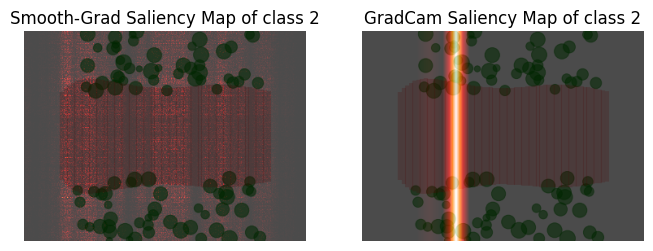

In [84]:
if single_pred2 == 2:
    print("Model correctly predicted 2")
    plot_saliency_correct(resnet18, model_modifier, val_img2, 2)
else:
    print("Model misclassified as: {}, but shoud be 2".format(single_pred2))
    plot_saliency_wrong(resnet18, model_modifier, val_img2, 2, single_pred2)

Model correctly predicted 3


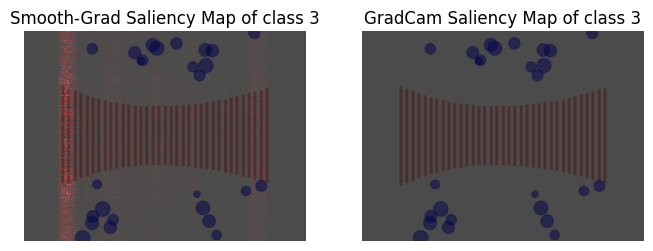

In [85]:
if single_pred3 == 3:
    print("Model correctly predicted 3")
    plot_saliency_correct(resnet18, model_modifier, val_img3, 3)
else:
    print("Model misclassified as: {}, but shoud be 3".format(single_pred3))
    plot_saliency_wrong(resnet18, model_modifier, val_img3, 3, single_pred3)

### Examine the test image
#### Test Image, class 1

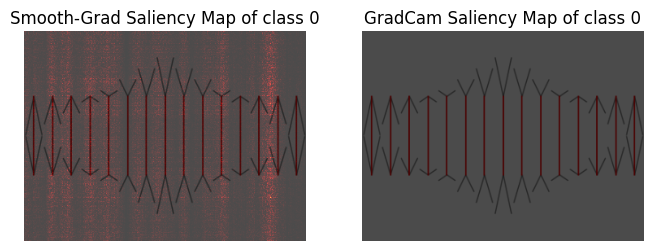

In [113]:
##correct classification example
index = np.where(prediction1==0)[0][0]
batch_size = 64
img = list(iter(normalized_testset1.skip(index//batch_size).take(1)))[0][index%batch_size]
plot_saliency_correct(resnet18, model_modifier, img, 0)

1/1 [==============================] - 0s 21ms/step


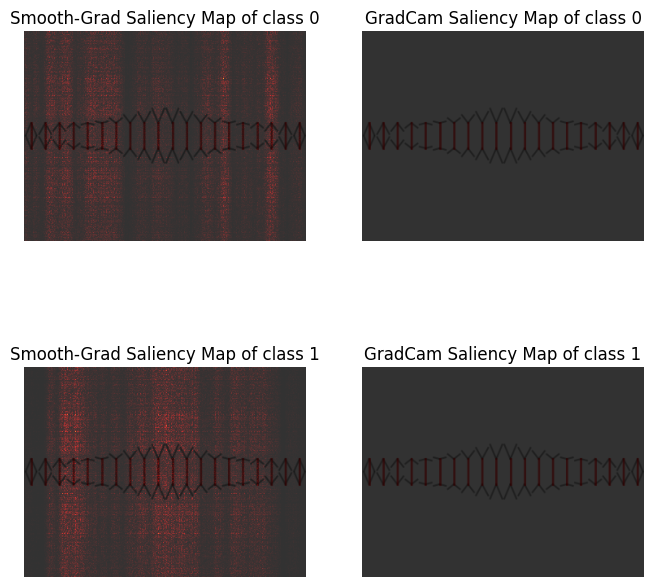

In [120]:
##misclassified as 1
index = np.where(prediction1==1)[0][0]
batch_size = 64
img = list(iter(normalized_testset1.skip(index//batch_size).take(1)))[0][index%batch_size]
pred = resnet18.predict(np.expand_dims(img, axis=0)).argmax()
plot_saliency_wrong(resnet18, model_modifier, img, 0, pred)

1/1 [==============================] - 0s 22ms/step


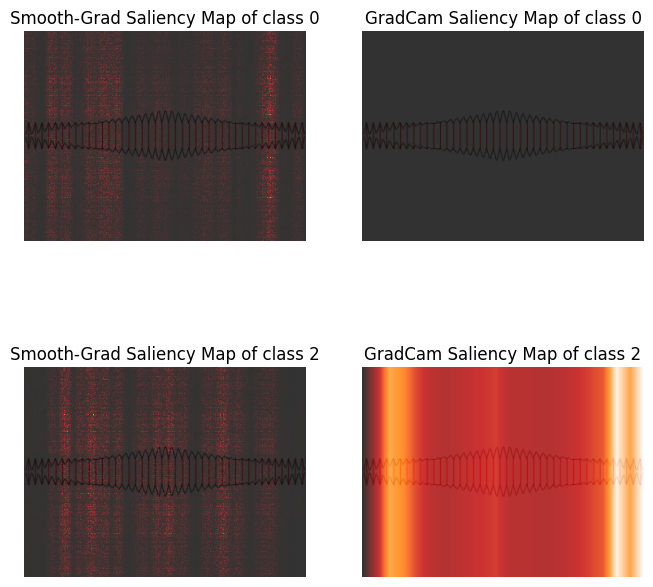

In [128]:
##misclassified as 2
index = np.where(prediction1==2)[0][-1]
batch_size = 64
img = list(iter(normalized_testset1.skip(index//batch_size).take(1)))[0][index%batch_size]
pred = resnet18.predict(np.expand_dims(img, axis=0)).argmax()
plot_saliency_wrong(resnet18, model_modifier, img, 0, pred)

1/1 [==============================] - 0s 21ms/step


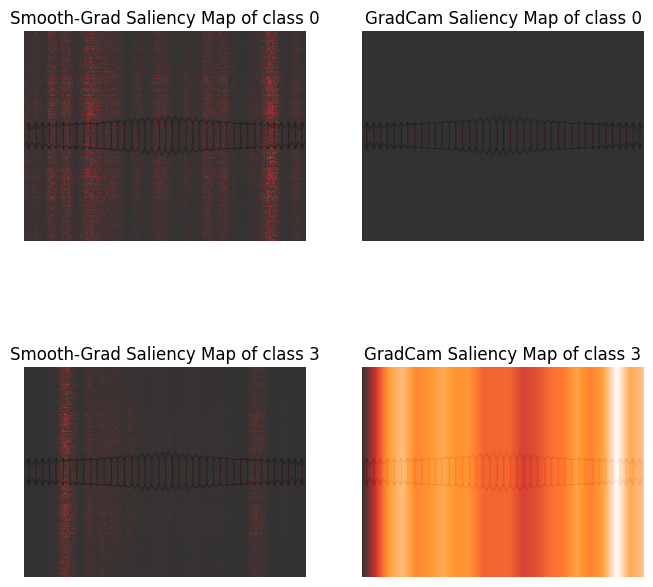

In [127]:
##misclassified as 3
index = np.where(prediction1==3)[0][-1]
batch_size = 64
img = list(iter(normalized_testset1.skip(index//batch_size).take(1)))[0][index%batch_size]
pred = resnet18.predict(np.expand_dims(img, axis=0)).argmax()
plot_saliency_wrong(resnet18, model_modifier, img, 0, pred)

#### Test Image, class 2

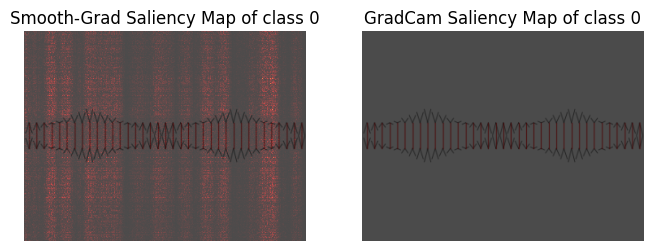

In [126]:
##correct classification example
index = np.where(prediction2==0)[0][1000]
batch_size = 64
img = list(iter(normalized_testset2.skip(index//batch_size).take(1)))[0][index%batch_size]
plot_saliency_correct(resnet18, model_modifier, img, 0)

1/1 [==============================] - 0s 21ms/step


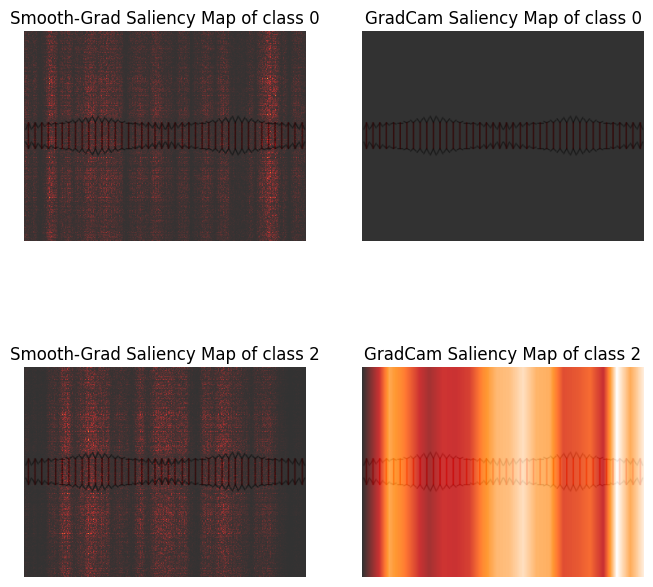

In [130]:
##misclassified as 2
index = np.where(prediction2==2)[0][-1]
batch_size = 64
img = list(iter(normalized_testset2.skip(index//batch_size).take(1)))[0][index%batch_size]
pred = resnet18.predict(np.expand_dims(img, axis=0)).argmax()
plot_saliency_wrong(resnet18, model_modifier, img, 0, pred)

1/1 [==============================] - 0s 21ms/step


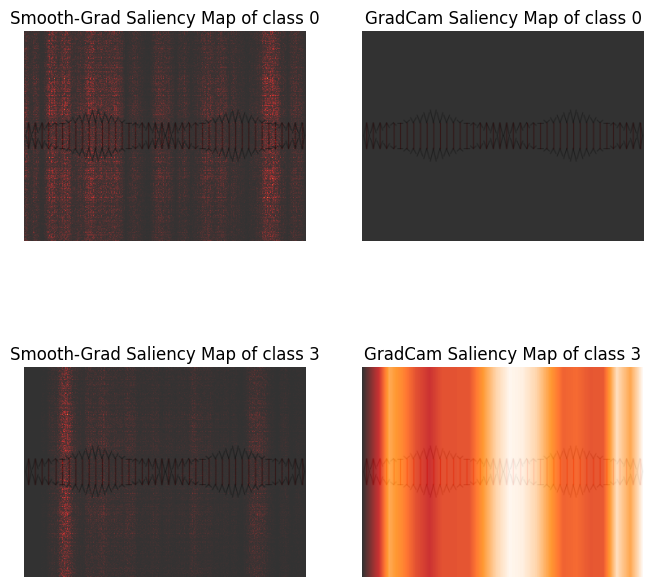

In [132]:
##misclassified as 3
index = np.where(prediction2==3)[0][-1]
batch_size = 64
img = list(iter(normalized_testset2.skip(index//batch_size).take(1)))[0][index%batch_size]
pred = resnet18.predict(np.expand_dims(img, axis=0)).argmax()
plot_saliency_wrong(resnet18, model_modifier, img, 0, pred)

#### Test Image, class 3

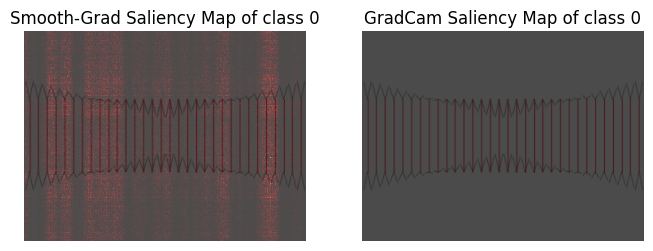

In [133]:
##correct classification example
index = np.where(prediction3==0)[0][1000]
batch_size = 64
img = list(iter(normalized_testset3.skip(index//batch_size).take(1)))[0][index%batch_size]
plot_saliency_correct(resnet18, model_modifier, img, 0)

1/1 [==============================] - 0s 21ms/step


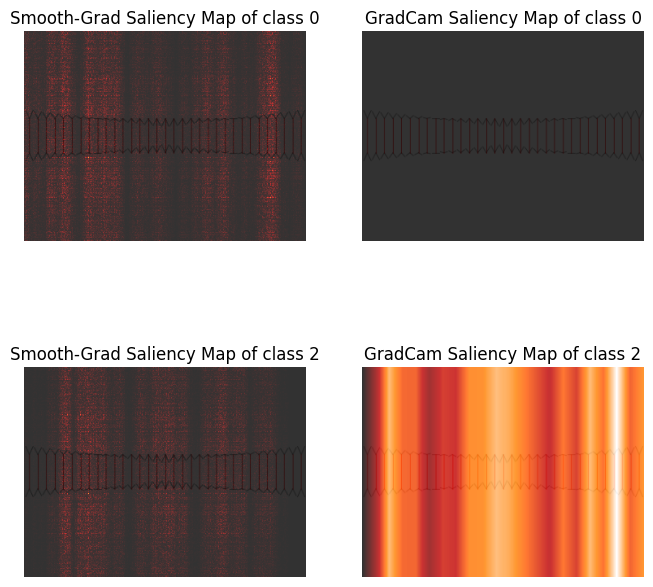

In [134]:
##misclassified as 2
index = np.where(prediction3==2)[0][-1]
batch_size = 64
img = list(iter(normalized_testset3.skip(index//batch_size).take(1)))[0][index%batch_size]
pred = resnet18.predict(np.expand_dims(img, axis=0)).argmax()
plot_saliency_wrong(resnet18, model_modifier, img, 0, pred)

1/1 [==============================] - 0s 21ms/step


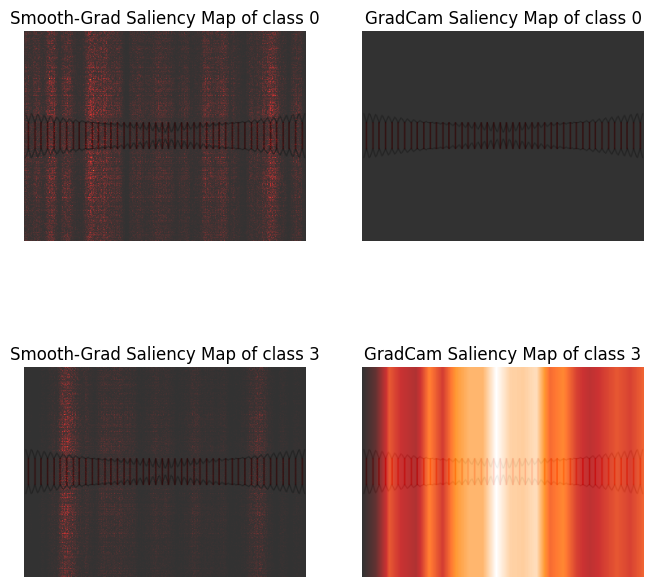

In [135]:
##misclassified as 3
index = np.where(prediction3==3)[0][-1]
batch_size = 64
img = list(iter(normalized_testset3.skip(index//batch_size).take(1)))[0][index%batch_size]
pred = resnet18.predict(np.expand_dims(img, axis=0)).argmax()
plot_saliency_wrong(resnet18, model_modifier, img, 0, pred)